In [60]:
%load_ext autoreload
%autoreload 2

import sys
import os
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from osgeo import gdal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Colormap
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline import load as pipeline
from reproduction.analysis import AEData, plot_cluster_channel_distributions, plot_cluster_samples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_dir = "../output/mod09cnn14/"

with open(model_dir + "ae.json", "r") as f:
    ae = tf.keras.models.model_from_json(f.read())
ae.load_weights(model_dir + "ae.h5")

In [3]:
def filename_contains_fn(substr):
    def fn (fnames, _, __):
        return tf.py_func(lambda fname: substr in str(fname), [fnames[0]], tf.bool, False)
    return fn

In [11]:
labeled_data =  pipeline.load_data(
    data_glob="../data/closed_open_cell/*.tfrecord",
    shape=(128, 128, 7),
    batch_size=32,
    read_threads=4,
    shuffle_buffer_size=100,
    prefetch=2
)

In [12]:
open_cells = labeled_data.filter(filename_contains_fn("open-cell"))
closed_cells = labeled_data.filter(filename_contains_fn("closed-cell"))

# Open vs Closed Cell Stratocumulus

In [13]:
fields = ["b%d"%(i+1) for i in range(7)]
n_test = 100
n_train = 2000
n = n_train + n_test

In [14]:
opens = AEData(open_cells, ae, fields, n)
closeds = AEData(closed_cells, ae, fields, n)

In [15]:
for d in (opens, closeds):
    nuniq = len(set((tuple(a), b) for a, b in zip(d.coords, d.names)))
    assert nuniq == n_test + n_train

In [16]:
classifier = SVC(kernel="poly")

## Baseline: Using only patch mean and stdev

In [17]:
base_features = np.stack([ 
    np.concatenate([opens.imgs.mean(axis=(1,2,3)), closeds.imgs.mean(axis=(1,2,3))]),
    np.concatenate([opens.imgs.std(axis=(1,2,3)), closeds.imgs.std(axis=(1,2,3))])
], axis=1)

b = classifier.fit(
    X=np.concatenate([
        base_features[:n_train],
        base_features[n: n+n_train]
    ]),
    y=([0] * n_train + [1] * n_train))

b.score(
    X=np.concatenate([base_features[n_train:n], base_features[n + n_train:]]),
    y=([0] * n_test + [1] * n_test),
)

0.625

In [18]:
base_features.std(axis=0)

array([0.5684016 , 0.25230455], dtype=float32)

In [19]:
b.decision_function_shape

'ovr'

## AE features

In [20]:
# ofeat = np.reshape(opens.raw_encs, (n, -1))
# cfeat = np.reshape(closeds.raw_encs, (n, -1))


# lr = classifier.fit(
#     X=np.concatenate([ofeat[:n_train], cfeat[:n_train]]),
#     y=([0] * n_train + [1] * n_train),
# )
# lr.score(
#     X=np.concatenate([ofeat[n_train:], cfeat[n_train:]]),
#     y=([0] * n_test + [1] * n_test),
# )

In [21]:
# plt.hist(lr.coef_.ravel());

## Spatially Averaged AE features

In [22]:
ofeat = opens.encs
cfeat = closeds.encs

sae = classifier.fit(
    X=np.concatenate([ofeat[:n_train], cfeat[:n_train]]),
    y=([0] * n_train + [1] * n_train),
)
sae.score(
    X=np.concatenate([ofeat[n_train:], cfeat[n_train:]]),
    y=([0] * n_test + [1] * n_test),
)

0.735

In [61]:
pred = sae.predict(np.concatenate([ofeat[n_train:], cfeat[n_train:]]))

In [64]:
pred.shape

(200,)

In [84]:
pred[n_test:] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1])

In [85]:
false_closeds = opens.imgs[n_train:n_train + n_test][pred[:n_test] != 0]
false_opens = closeds.imgs[n_train:n_train + n_test][pred[n_test:] != 1]

In [86]:
print(false_opens.shape, false_closeds.shape)

(24, 128, 128, 7) (29, 128, 128, 7)


### Data "Open" Classified as "Closed"

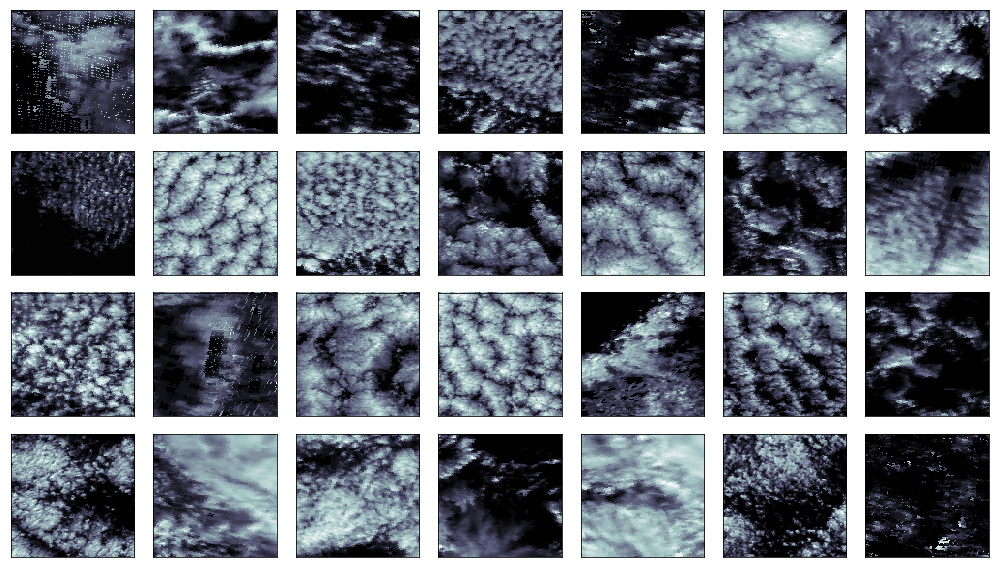

In [87]:
_, ax = plt.subplots(nrows=4, ncols=7, figsize=(14, 8))

for i, a in enumerate(ax.ravel()):
    a.imshow(false_closeds[i,:,:,0], cmap="bone")
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()

### Data: "Closed",  Classifier: "Open"

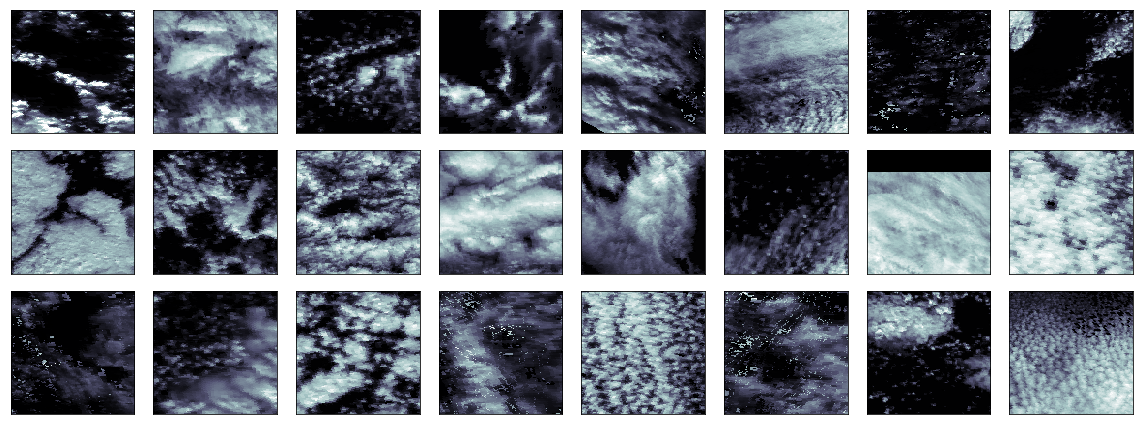

In [88]:
_, ax = plt.subplots(nrows=3, ncols=8, figsize=(16, 6))

for i, a in enumerate(ax.ravel()):
    a.imshow(false_opens[i,:,:,0], cmap="bone")
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()

## mean/std of AE features


In [23]:
_features = np.stack([ 
    np.concatenate([ofeat.mean(axis=1), cfeat.mean(axis=1)]),
    np.concatenate([ofeat.std(axis=1), cfeat.std(axis=1)])
], axis=1)

msae = classifier.fit(
    X=np.concatenate([
        _features[:n_train],
        _features[n: n+n_train]
    ]),
    y=([0] * n_train + [1] * n_train)
)

msae.score(
    X=np.concatenate([_features[n_train:n], _features[n + n_train:]]),
    y=([0] * n_test + [1] * n_test),
)

0.45

In [24]:
lr_b.coef_

NameError: name 'lr_b' is not defined

## Top `d` Principle Components of spatial mean AE features


In [22]:
# data = AEData(
#     dataset=pipeline.load_data(
#         data_glob="../data/tif/*.tfrecord",
#         shape=(128, 128, 7),
#         batch_size=32,
#         read_threads=4,
#         shuffle_buffer_size=100,
#         prefetch=2
#     ),
#     ae=ae,
#     fields=["b%d"%(i+1) for i in range(7)],
#     n=1000
# )

In [29]:
d = 64

In [ ]:
_features = np.concatenate([
    data.pca_project(opens, d).T,
    data.pca_project(closeds, d).T
])

ae3 = classifier.fit(
    X=np.concatenate([
        _features[:n_train],
        _features[n: n+n_train]
    ]),
    y=([0] * n_train + [1] * n_train)
)

ae3.score(
    X=np.concatenate([_features[n_train:n], _features[n + n_train:]]),
    y=([0] * n_test + [1] * n_test),
)

Rotating into principle component axis improves things a bit, I think its because the L1 regularization is axis aligned. PCA has independent components.

In [ ]:
plt.hist(lr.coef_.ravel());
plt.yscale("log")

# Homogeniety metrics vs clusters